## Fashion MNIST 분류 모델

In [1]:
import torch
from torchvision.transforms import transforms
from torchvision import datasets
import torchmetrics

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 데이터 로드

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, ))])

In [3]:
trainset = datasets.FashionMNIST(root='/content/', train=True,
                                 download=True, transform=transform)
testset = datasets.FashionMNIST(root='/content/', train=True,
                                 download=False, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(trainset, batch_size=128,
                          shuffle=True, num_workers=2) # num_workers : N개의 코어 처리
test_loader = DataLoader(trainset, batch_size=128,
                         shuffle=False, num_workers=2)

In [5]:
images, labels = next(iter(train_loader))
images.shape, labels.shape, 
# image shape : (Batch Size, Channel, Size, Size)

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

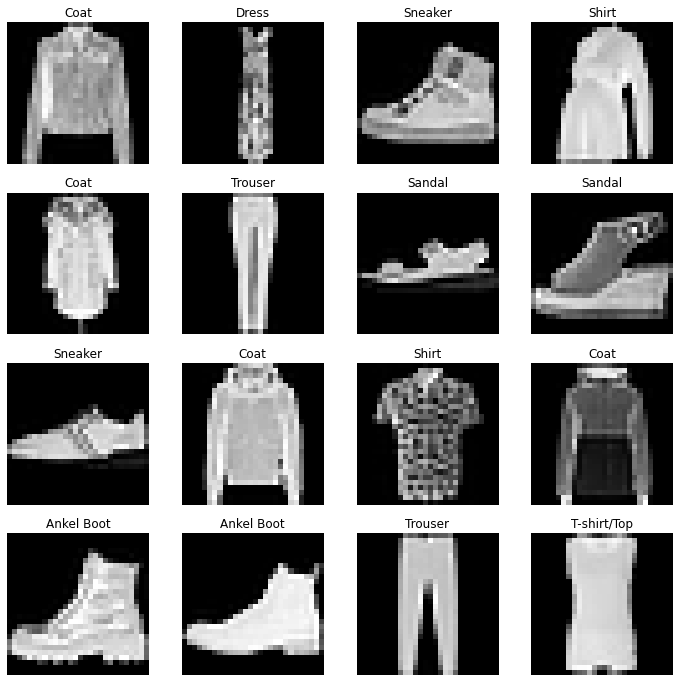

In [6]:
# Label 지정
labels_map = {
    0:'T-shirt/Top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankel Boot'}

figure = plt.figure(figsize=(12,12))
cols, rows = 4,4 # 4*4 = 16개 이미지 출력

for i in range(1, cols * rows +1):
    image = images[i].squeeze() # Channel 차원 축소
    label_idx = labels[i].item() # Tensor 값 추출
    label = labels_map[label_idx]
    
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    
plt.show();

### 모델 정의 및 파라미터

In [7]:
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 128, 3)
        self.conv2 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(256 * 5 * 5, 128) # Fully Connected
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
            
        return num_features
    
net = NeuralNet()
print(net)

NeuralNet(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [8]:
net = NeuralNet().to(device)

In [9]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([128, 1, 3, 3])


In [10]:
input = torch.randn(1, 1, 28, 28)
out = net(input.to(device))
print(out)

tensor([[-0.0247, -0.0830, -0.0385, -0.0767, -0.0574, -0.1285, -0.0881, -0.0828,
          0.0283,  0.0794]], device='cuda:0', grad_fn=<AddmmBackward0>)


### 손실함수 및 옵티마이저

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### 모델 학습

#### 배치 수 확인

In [12]:
# 전체 배치 계산
total_batch = len(train_loader)
print(total_batch)

# 469번 수행

469


In [13]:
# GPU 사용

for epoch in range(10):
    
    running_loss = 0.0 # Running Loss 초기화
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # GPU로 전송
        
        optimizer.zero_grad() # 초기화
        
        outputs = net(inputs)
        loss = criterion(outputs, labels) # outputs : prediction / labels : y
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:
            print('Epoch : {}, Iter : {}, Loss : {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch : 1, Iter : 100, Loss : 0.03756152634322643
Epoch : 1, Iter : 200, Loss : 0.024181052803993224
Epoch : 1, Iter : 300, Loss : 0.02025721101462841
Epoch : 1, Iter : 400, Loss : 0.01859242194145918
Epoch : 2, Iter : 100, Loss : 0.01673175713419914
Epoch : 2, Iter : 200, Loss : 0.015821292765438557
Epoch : 2, Iter : 300, Loss : 0.014916672632098197
Epoch : 2, Iter : 400, Loss : 0.014261785462498665
Epoch : 3, Iter : 100, Loss : 0.012658030189573765
Epoch : 3, Iter : 200, Loss : 0.012630301270633935
Epoch : 3, Iter : 300, Loss : 0.012474156077951193
Epoch : 3, Iter : 400, Loss : 0.011903431333601475
Epoch : 4, Iter : 100, Loss : 0.010602262195199727
Epoch : 4, Iter : 200, Loss : 0.010835527159273625
Epoch : 4, Iter : 300, Loss : 0.010630329854786395
Epoch : 4, Iter : 400, Loss : 0.01031859978660941
Epoch : 5, Iter : 100, Loss : 0.00916287575662136
Epoch : 5, Iter : 200, Loss : 0.009079891331493855
Epoch : 5, Iter : 300, Loss : 0.009333384454250335
Epoch : 5, Iter : 400, Loss : 0.00872

### 모델 저장 및 로드

- torch.save : net.state_dict() 저장
- torch.load : load_state_dict 로드

In [14]:
path = './fashion_mnist.pth'
torch.save(net.state_dict(), path)

In [15]:
net = NeuralNet()
net.load_state_dict(torch.load(path))

<All keys matched successfully>

### 모델 테스트

In [16]:
def imshow(image):
    image = image / 2 + 0.5
    npimg = image.numpy()
    
    fig = plt.figure(figsize=(16,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 채널 순서를 위한 순서 변환
    plt.show();

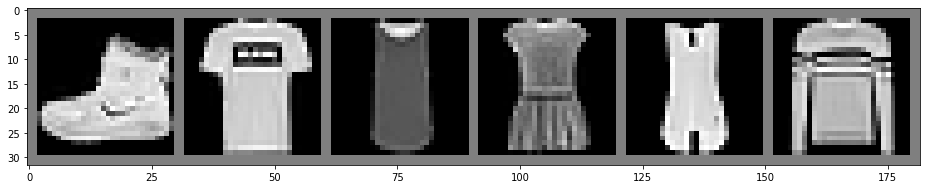

In [17]:
import torchvision

dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:6]))

In [18]:
# Test 값을 통해 예측 실행

outputs = net(images)

_, predicted = torch.max(outputs, 1)
# 10개 class 분류에 대한 모델이 예측한 최종 결과값 중 가장 큰 백분율값 선택

print(predicted)

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 0, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1,
        6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7, 9, 9, 9, 3, 2, 9, 3, 6,
        4, 1, 1, 8, 8, 0, 1, 1, 6, 8, 1, 9, 7, 8, 8, 9, 6, 6, 3, 1, 5, 4, 6, 7,
        5, 5, 9, 2, 2, 2, 7, 6])


In [19]:
print(''.join('{}, '.format(labels_map[int(predicted[j].numpy())]) for j in range(6)))

Ankel Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, 


In [20]:
# 전체 정확도 확인

from tqdm import tqdm

correct = 0
total = 0

with torch.no_grad(): # 평가이므로 Gradient 중지
    for data in tqdm(test_loader):
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(100 * correct / total)

100%|██████████| 469/469 [02:00<00:00,  3.90it/s]

98.00833333333334
